## Dependencies

In [10]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report,confusion_matrix
import pickle

## Load  Data

In [12]:
TRAIN_CSV = '../Dataset/train_cleaned.csv'
TEST_CSV = '../Dataset/test_cleaned.csv'

In [13]:
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,satisfaction
0,13,460,3,4,3,1,5,3,5,5,...,False,True,True,False,False,True,False,False,True,False
1,25,235,3,2,3,3,1,3,1,1,...,False,True,False,True,True,False,True,False,False,False
2,26,1142,2,2,2,2,5,5,5,5,...,True,False,True,False,True,False,True,False,False,True
3,25,562,2,5,5,5,2,2,2,2,...,True,False,True,False,True,False,True,False,False,False
4,61,214,3,3,3,3,4,5,5,3,...,False,True,True,False,True,False,True,False,False,True


## Model Training


Training with 100 trees...

Training with 200 trees...

Training with 500 trees...

Training with 1000 trees...


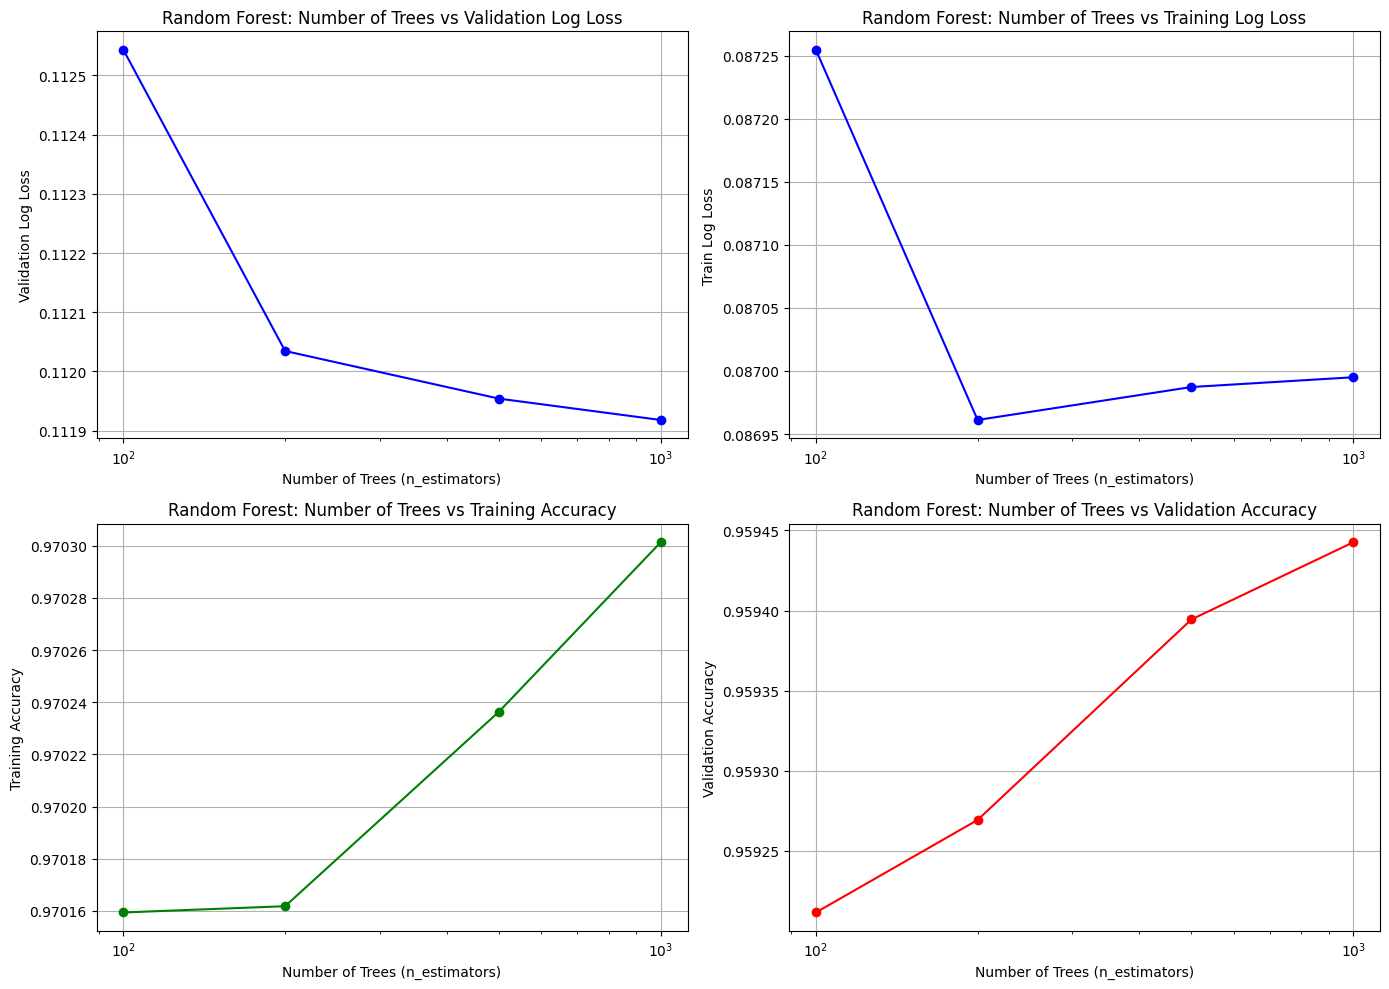

In [14]:
X = train_df.drop(columns=['satisfaction'])
y = train_df['satisfaction']
num_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes']

#! scale numerical features 
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'  
)
X = ct.fit_transform(X)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
n_estimators_values = [100, 200, 500,1000]
mean_losses = []
mean_train_accuracies = []
mean_val_accuracies = []
mean_train_losses = []
for n_estimators in n_estimators_values:
    print(f"\nTraining with {n_estimators} trees...")
    model = RandomForestClassifier(n_estimators=n_estimators, criterion ='gini',random_state=42, n_jobs=-1, max_depth=18,min_samples_leaf=5, class_weight='balanced')

    # Negative log loss (lower is better)
    scores = cross_validate(model, X, y, cv=kf, 
                            scoring=['accuracy', 'neg_log_loss'], 
                            return_train_score=True)
    
    loss = -scores['test_neg_log_loss'].mean()  # Mean negative log loss for the validation set
    train_loss = -scores['train_neg_log_loss'].mean()  # Mean negative log loss for the training set
    mean_losses.append(loss)
    
    train_accuracy = scores['train_accuracy'].mean()  # Mean training accuracy
    val_accuracy = scores['test_accuracy'].mean()  # Mean validation accuracy
    mean_train_accuracies.append(train_accuracy)
    mean_val_accuracies.append(val_accuracy)
    mean_train_losses.append(train_loss)

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(n_estimators_values, mean_losses, marker='o', color='blue')
axs[0, 0].set_xscale('log')
axs[0, 0].set_xlabel('Number of Trees (n_estimators)')
axs[0, 0].set_ylabel('Validation Log Loss')
axs[0, 0].set_title('Random Forest: Number of Trees vs Validation Log Loss')
axs[0, 0].grid(True)

axs[0, 1].plot(n_estimators_values, mean_train_losses, marker='o', color='blue')
axs[0, 1].set_xscale('log')
axs[0, 1].set_xlabel('Number of Trees (n_estimators)')
axs[0, 1].set_ylabel('Train Log Loss')
axs[0, 1].set_title('Random Forest: Number of Trees vs Training Log Loss')
axs[0, 1].grid(True)

axs[1, 0].plot(n_estimators_values, mean_train_accuracies, marker='o', color='green')
axs[1, 0].set_xscale('log')
axs[1, 0].set_xlabel('Number of Trees (n_estimators)')
axs[1, 0].set_ylabel('Training Accuracy')
axs[1, 0].set_title('Random Forest: Number of Trees vs Training Accuracy')
axs[1, 0].grid(True)

axs[1, 1].plot(n_estimators_values, mean_val_accuracies, marker='o', color='red')
axs[1, 1].set_xscale('log')
axs[1, 1].set_xlabel('Number of Trees (n_estimators)')
axs[1, 1].set_ylabel('Validation Accuracy')
axs[1, 1].set_title('Random Forest: Number of Trees vs Validation Accuracy')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [15]:
best_N = n_estimators_values[np.argmax(mean_val_accuracies)]
print(f'best_N: {best_N}')


best_N: 1000


In [16]:
model = RandomForestClassifier(n_estimators=best_N, random_state=42, n_jobs=-1, max_depth=20, class_weight='balanced')
model.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=1000,
                       n_jobs=-1, random_state=42)

## Training Metrics

In [17]:
y_pred = model.predict(X)
accuracy = accuracy_score(y, y_pred)


print("\nClassification Report:\n")
print(classification_report(y, y_pred))


Classification Report:

              precision    recall  f1-score   support

       False       0.99      1.00      1.00     58878
        True       1.00      0.99      0.99     45024

    accuracy                           0.99    103902
   macro avg       0.99      0.99      0.99    103902
weighted avg       0.99      0.99      0.99    103902



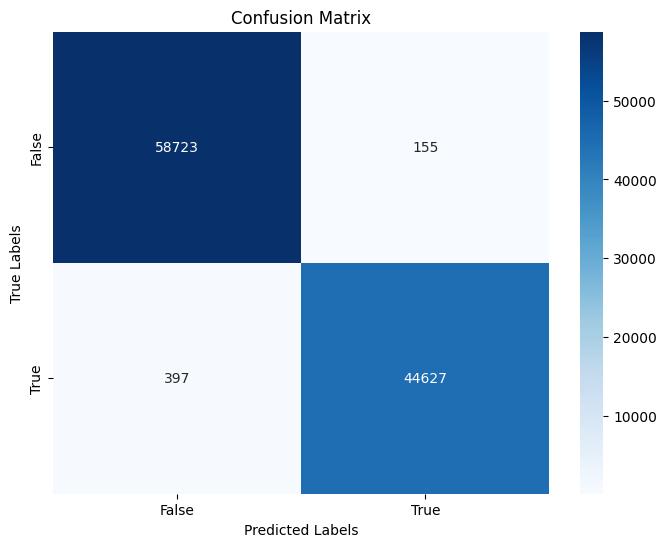

In [18]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Test Metrics

In [19]:
test_df = pd.read_csv(TEST_CSV)
X_test = test_df.drop(columns=['satisfaction'])
y_test = test_df['satisfaction']
X_test = ct.fit_transform(X_test)

In [20]:
y_pred_test = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)


print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_test))


Classification Report:

              precision    recall  f1-score   support

       False       0.96      0.98      0.97     14572
        True       0.97      0.95      0.96     11403

    accuracy                           0.96     25975
   macro avg       0.96      0.96      0.96     25975
weighted avg       0.96      0.96      0.96     25975



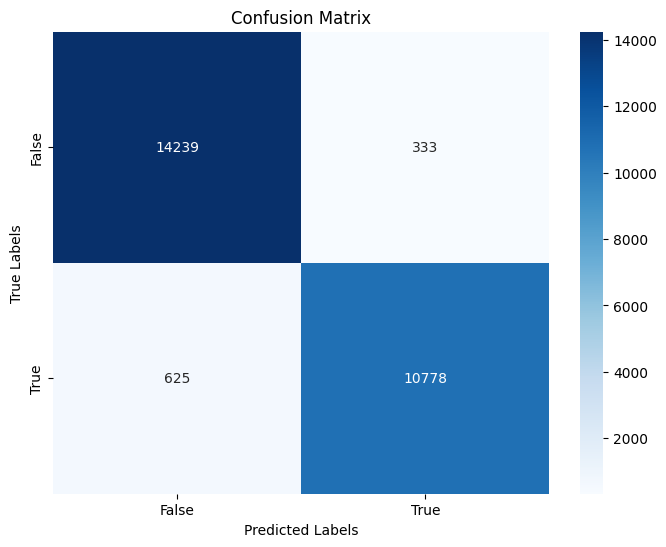

In [21]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [22]:
pickle.dump(model, open('../Models/RFModel.pkl', 'wb'))